In [1]:
# !IMPORTANT - to run this notebook download first "corpus" dataset from 
# dataset https://gist.github.com/kunalj101/ad1d9c58d338e20d09ff26bcc06c4235 and put it in same folder as for this notebook
# then import wiki-news-300d-1M.vec from https://www.kaggle.com/datasets/facebook/fasttext-wikinews

In [1]:
#import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import ensemble
from keras import layers, models, optimizers
import numpy
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')

# import dataset
# __label__2 - positive review
# __label__1 - negative review
data = open('data/corpus').read()

#fill lists with reviews and labels
labels, texts = [], []
for i, line in enumerate(data.split("\n")): 
    content = line.split()
    labels.append(content[0])
    texts.append(" ".join(content[1:]))

# create DataFrame
trainDF = pd.DataFrame()
# add texts to DataFrame
trainDF['text'] = texts
# add labels to DataFrame
trainDF['label'] = labels

#display first 100 records
print(trainDF.head(100))
#show statics information
print(trainDF.describe())

2023-12-18 19:37:04.412642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 19:37:04.682191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-18 19:37:04.682210: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-18 19:37:05.544286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

                                                 text       label
0   Stuning even for the non-gamer: This sound tra...  __label__2
1   The best soundtrack ever to anything.: I'm rea...  __label__2
2   Amazing!: This soundtrack is my favorite music...  __label__2
3   Excellent Soundtrack: I truly like this soundt...  __label__2
4   Remember, Pull Your Jaw Off The Floor After He...  __label__2
..                                                ...         ...
95  Very Not Worth Your Time: The book was wriiten...  __label__1
96  Very fun and educational: Trains, shapes and p...  __label__2
97  Ludicrous and silly: I remember getting this b...  __label__1
98  Artistry: I think that the Deodato concerts ar...  __label__2
99  Caution!: These tracks are not the "original" ...  __label__1

[100 rows x 2 columns]
                                                     text       label
count                                               10000       10000
unique                                      

[nltk_data] Downloading package stopwords to /home/michal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/michal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# analyze dataset
# check number of words in each review
train = trainDF.copy()
train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))
print(train[['text','word_count']].head())
print(train['word_count'].max())
print(train['word_count'].min())
print(train['word_count'].mean())

                                                text  word_count
0  Stuning even for the non-gamer: This sound tra...          80
1  The best soundtrack ever to anything.: I'm rea...          97
2  Amazing!: This soundtrack is my favorite music...         129
3  Excellent Soundtrack: I truly like this soundt...         118
4  Remember, Pull Your Jaw Off The Floor After He...          87
212
14
79.5532


In [4]:
# check character number
train['char_count'] = train['text'].str.len() ## this also includes spaces
train[['text','char_count']].head()

,text,char_count
0,Stuning even for the non-gamer: This sound tra...,426
1,The best soundtrack ever to anything.: I'm rea...,509
2,Amazing!: This soundtrack is my favorite music...,760
3,Excellent Soundtrack: I truly like this soundt...,743
4,"Remember, Pull Your Jaw Off The Floor After He...",481


In [5]:
# check average word length

def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['text'].apply(lambda x: avg_word(x))
train[['text','avg_word']].head()

,text,avg_word
0,Stuning even for the non-gamer: This sound tra...,4.337500
1,The best soundtrack ever to anything.: I'm rea...,4.257732
2,Amazing!: This soundtrack is my favorite music...,4.899225
3,Excellent Soundtrack: I truly like this soundt...,5.305085
4,"Remember, Pull Your Jaw Off The Floor After He...",4.540230


In [6]:
# check number of stop-words (stop-words are common words not important for analysis)

stop = stopwords.words('english')

train['stopwords'] = train['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['text','stopwords']].head()

,text,stopwords
0,Stuning even for the non-gamer: This sound tra...,29
1,The best soundtrack ever to anything.: I'm rea...,42
2,Amazing!: This soundtrack is my favorite music...,48
3,Excellent Soundtrack: I truly like this soundt...,33
4,"Remember, Pull Your Jaw Off The Floor After He...",28


In [7]:
# check numeric characters number

train['numerics'] = train['text'].apply(lambda x: len([x for x in x.split(' ') if x.isnumeric()]))
print(train[['text','numerics']].head())
print(train['numerics'].max())
print(train['numerics'].min())
print(train['numerics'].mean())

                                                text  numerics
0  Stuning even for the non-gamer: This sound tra...         0
1  The best soundtrack ever to anything.: I'm rea...         0
2  Amazing!: This soundtrack is my favorite music...         1
3  Excellent Soundtrack: I truly like this soundt...         0
4  Remember, Pull Your Jaw Off The Floor After He...         0
13
0
0.3557


In [8]:
# check number of upper case letters

train['upper'] = train['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
print(train[['text','upper']].head())

train['capital'] = train['text'].apply(lambda x: len([x for x in x.split(' ') if x[0].isupper()]))
print(train['capital'].max())
print(train['capital'].min())
print(train['capital'].mean())

                                                text  upper
0  Stuning even for the non-gamer: This sound tra...      3
1  The best soundtrack ever to anything.: I'm rea...      3
2  Amazing!: This soundtrack is my favorite music...      4
3  Excellent Soundtrack: I truly like this soundt...      4
4  Remember, Pull Your Jaw Off The Floor After He...      0
179
0
11.2266


In [9]:
# check number of punctuation characters

train['punctuation'] = train['text'].apply(lambda x: len(re.findall(r'[\.,?!;:]', x)))
print(train[['text','upper']].head())

train['punctuation'] = train['text'].apply(lambda x: len([x for x in x.split(' ') if x[0].isupper()]))
print(train['punctuation'].max())
print(train['punctuation'].min())
print(train['punctuation'].mean())

                                                text  upper
0  Stuning even for the non-gamer: This sound tra...      3
1  The best soundtrack ever to anything.: I'm rea...      3
2  Amazing!: This soundtrack is my favorite music...      4
3  Excellent Soundtrack: I truly like this soundt...      4
4  Remember, Pull Your Jaw Off The Floor After He...      0
179
0
11.2266


In [10]:
# normalize text
# apply lowercase

trainDFRaw = trainDF.copy()

trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
trainDF['text'].head()

0    stuning even for the non-gamer: this sound tra...
1    the best soundtrack ever to anything.: i'm rea...
2    amazing!: this soundtrack is my favorite music...
3    excellent soundtrack: i truly like this soundt...
4    remember, pull your jaw off the floor after he...
Name: text, dtype: object

In [11]:
# remove special characters

trainDF['text'] = trainDF['text'].str.replace('[^\w\s]','')
trainDF['text'].head()

/tmp/ipykernel_13157/522430754.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  trainDF['text'] = trainDF['text'].str.replace('[^\w\s]','')


0    stuning even for the nongamer this sound track...
1    the best soundtrack ever to anything im readin...
2    amazing this soundtrack is my favorite music o...
3    excellent soundtrack i truly like this soundtr...
4    remember pull your jaw off the floor after hea...
Name: text, dtype: object

In [12]:
# usunięcie słów "stopwords"

stop = stopwords.words('english')
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
trainDF['text'].head()

0    stuning even nongamer sound track beautiful pa...
1    best soundtrack ever anything im reading lot r...
2    amazing soundtrack favorite music time hands i...
3    excellent soundtrack truly like soundtrack enj...
4    remember pull jaw floor hearing youve played g...
Name: text, dtype: object

In [13]:
# prepare list of most frequent words

freq = pd.Series(' '.join(trainDF['text']).split()).value_counts()[:20]
freq

book      6496
one       3857
like      2813
good      2769
read      2740
great     2719
movie     2543
would     2381
get       1931
time      1903
dont      1771
really    1604
first     1444
much      1419
even      1400
well      1362
story     1334
buy       1233
love      1193
best      1107
dtype: int64

In [14]:
# remove most frequent words

freq = list(freq.index)
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
trainDF['text'].head()

0    stuning nongamer sound track beautiful paints ...
1    soundtrack ever anything im reading lot review...
2    amazing soundtrack favorite music hands intens...
3    excellent soundtrack truly soundtrack enjoy vi...
4    remember pull jaw floor hearing youve played g...
Name: text, dtype: object

In [15]:
# prepare list of rare words

freq = pd.Series(' '.join(trainDF['text']).split()).value_counts()[-20:]
freq

christmasand          1
550                   1
childrenguaranteed    1
marriedwith           1
roommatesa            1
bathtub               1
sooooooooooo          1
rulz                  1
killer06              1
seasonalready         1
dogs05                1
niece04               1
four03                1
house02               1
episodes01            1
goodhere              1
dvdbut                1
outno                 1
timesjohn             1
graduation            1
dtype: int64

In [16]:
# remove rare words

freq = list(freq.index)
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
trainDF['text'].head()

0    stuning nongamer sound track beautiful paints ...
1    soundtrack ever anything im reading lot review...
2    amazing soundtrack favorite music hands intens...
3    excellent soundtrack truly soundtrack enjoy vi...
4    remember pull jaw floor hearing youve played g...
Name: text, dtype: object

In [17]:
# fix typos

from textblob import TextBlob
trainDF['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    tuning nongamer sound track beautiful points s...
1    soundtrack ever anything in reading lot review...
2    amazing soundtrack favorite music hands intens...
3    excellent soundtrack truly soundtrack enjoy vi...
4    remember pull jaw floor hearing you played gam...
Name: text, dtype: object

In [18]:
#lemmatize - unify words with same language core

from textblob import Word
nltk.download('wordnet')

trainDF = trainDF.copy()
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
trainDF['text'].head()

[nltk_data] Downloading package wordnet to /home/michal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    stuning nongamer sound track beautiful paint s...
1    soundtrack ever anything im reading lot review...
2    amazing soundtrack favorite music hand intense...
3    excellent soundtrack truly soundtrack enjoy vi...
4    remember pull jaw floor hearing youve played g...
Name: text, dtype: object

In [19]:
# prepare model
# split data to train and test set
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

# encode categorical values
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

print(valid_y)

[1 0 0 ... 0 1 0]


In [20]:
# encode text to TF-IDF numeric vectors

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)


In [21]:
# universal method for model training

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # train model
    classifier.fit(feature_vector_train, label)
    
    # generate predictions for test set
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    # evaluate model
    scores = list(metrics.precision_recall_fscore_support(predictions, valid_y))
    score_vals = [
        scores[0][0],
        scores[1][0],
        scores[2][0]
    ]
    score_vals.append(metrics.accuracy_score(predictions, valid_y))
    return score_vals

In [22]:
# MODEL 1 - logistic regression
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare = {'LR': accuracy}
print ("LR, WordLevel TF-IDF: ", accuracy)

LR, WordLevel TF-IDF:  [0.8343701399688958, 0.8448818897637795, 0.8395931142410015, 0.836]


In [23]:
# MODEL 2 - Support Vector Machine

accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare['SVM'] = accuracy
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  [0.8351477449455676, 0.8490118577075099, 0.8420227361818895, 0.8388]


In [24]:
# MODEL 3 - Random Forest Tree 
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare['RF'] = accuracy
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, WordLevel TF-IDF:  [0.8242612752721618, 0.8048595292331056, 0.8144448713023436, 0.8068]


In [27]:
# coding words as vectors with encoded meaning - word embeddings

from keras.preprocessing import text, sequence
from keras.utils import pad_sequences

# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(trainDF['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
# MODEL 4 - convolutional neural network with word embeddings

def create_cnn():
    # add input layer
    input_layer = layers.Input((70, ))

    # add encoding layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # add convolutional layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # add connection layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # add aoutput layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # compile model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compare['CNN'] = accuracy
print ("CNN, Word Embeddings",  accuracy)

2023-06-25 11:47:44.908183: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-25 11:47:44.908205: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-25 11:47:44.908219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (michal-ThinkPad-E14-Gen-3): /proc/driver/nvidia/version does not exist
2023-06-25 11:47:44.908584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


79/79 [==============================] - 1s 4ms/step
CNN, Word Embeddings [1.0, 0.5144, 0.6793449550977284, 0.5144]


/home/michal/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

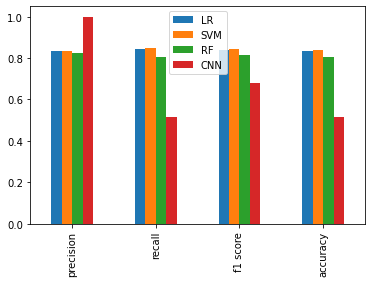

In [29]:
# evaluate models
# compare models

df_compare = pd.DataFrame(accuracy_compare, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare.plot(kind='bar')

<AxesSubplot:>

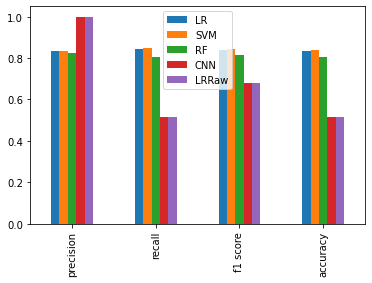

In [30]:
# without text normalization

# split to train and test set
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDFRaw['text'], trainDFRaw['label'])

# encode to numeric vectors
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

# encode as TF-IDF

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# MODEL 1 - logistic regression
accuracy_compare['LRRaw'] = accuracy
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)

df_compare = pd.DataFrame(accuracy_compare, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare.plot(kind='bar')